# Predictors next day price
The goal of this notebook is to predict through regressors the next day High, Low, Close, Volume and eventually looping to get a 20, 30 days prediction.

## Lib

In [2]:
import pandas as pd
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import os

## Indicators function
below are defined the indicators for the model.

In [3]:
def bb(high, low, close, window=20, num_std=2, use_typical_price=False):
    """
    Compute Bollinger Bands using NumPy.
    
    :param high: NumPy array of high prices.
    :param low: NumPy array of low prices.
    :param close: NumPy array of close prices.
    :param window: Window size for calculations (default 20).
    :param num_std: Number of standard deviations (default 2).
    :param use_typical_price: Use typical price (H+L+C)/3 if True, else use close.
    :return: Tuple of NumPy arrays (middle, upper, lower, relative_position).
    """
    high = np.asarray(high, dtype=float)
    low = np.asarray(low, dtype=float)
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    if len(high) != original_length or len(low) != original_length:
        raise ValueError("High, low, and close arrays must have the same length.")
    
    price = (high + low + close) / 3 if use_typical_price else close
    
    def rolling_mean(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        return np.concatenate((np.full(w-1, np.nan), rm, 
                              np.full(original_length - (len(rm) + w - 1), np.nan)))
    
    def rolling_std(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        cumsum_sq = np.cumsum(arr**2)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        rm_sq = (cumsum_sq[w:] - cumsum_sq[:-w]) / w
        var = np.maximum(rm_sq - rm**2, 0)
        result = np.sqrt(var)
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    middle = rolling_mean(price, window)
    std = rolling_std(price, window)
    upper = middle + num_std * std
    lower = middle - num_std * std
    
    # Suppress divide-by-zero and invalid value warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        band_width = upper - lower
        relative_position = np.where(band_width != 0, 200 * (close - middle) / band_width, np.nan)
    
    if not (len(middle) == len(upper) == len(lower) == len(relative_position) == original_length):
        raise ValueError(f"Length mismatch: middle={len(middle)}, upper={len(upper)}, "
                         f"lower={len(lower)}, relative_position={len(relative_position)}, "
                         f"expected={original_length}")
    
    return middle, upper, lower, relative_position




def rsi(close, window=14):
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    delta = np.diff(close)
    gain = np.maximum(delta, 0)
    loss = np.maximum(-delta, 0)
    
    def rolling_mean(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        return np.concatenate((np.full(w-1, np.nan), rm, 
                              np.full(original_length - 1 - (len(rm) + w - 1), np.nan)))
    
    avg_gain = rolling_mean(gain, window)
    avg_loss = rolling_mean(loss, window)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi_ = 100 - (100 / (1 + rs))
    
    result = np.concatenate(([np.nan], rsi_))
    if len(result) < original_length:
        result = np.concatenate((result, np.full(original_length - len(result), np.nan)))
    
    return result


def keltner_channels(high, low, close, ema_period=20, atr_period=14, atr_multiplier=2):
    """
    Compute Keltner Channels using NumPy.
    
    :param high: NumPy array of high prices.
    :param low: NumPy array of low prices.
    :param close: NumPy array of close prices.
    :param ema_period: Period for EMA calculation (default 20).
    :param atr_period: Period for ATR calculation (default 14).
    :param atr_multiplier: Multiplier for ATR (default 2).
    :return: Tuple of NumPy arrays (ema, upper, lower, relative_position).
    """
    high = np.asarray(high, dtype=float)
    low = np.asarray(low, dtype=float)
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    if len(high) != original_length or len(low) != original_length:
        raise ValueError("High, low, and close arrays must have the same length.")
    
    # Check if input length is sufficient
    if original_length < ema_period or original_length < atr_period:
        return (np.full(original_length, np.nan), 
                np.full(original_length, np.nan), 
                np.full(original_length, np.nan), 
                np.full(original_length, np.nan))
    
    alpha = 2 / (ema_period + 1)
    ema = np.full_like(close, np.nan, dtype=float)
    ema[ema_period-1] = np.mean(close[:ema_period])
    for i in range(ema_period, len(close)):
        ema[i] = alpha * close[i] + (1 - alpha) * ema[i-1]
    
    tr = np.maximum(np.maximum(high - low, np.abs(high - np.roll(close, 1))), 
                    np.abs(low - np.roll(close, 1)))
    tr[0] = np.nan
    cumsum = np.cumsum(tr)
    atr = np.concatenate((np.full(atr_period-1, np.nan), 
                         (cumsum[atr_period:] - cumsum[:-atr_period]) / atr_period))
    
    if len(atr) < original_length:
        atr = np.concatenate((atr, np.full(original_length - len(atr), np.nan)))
    
    upper = ema + atr_multiplier * atr
    lower = ema - atr_multiplier * atr
    
    with np.errstate(divide='ignore', invalid='ignore'):
        channel_width = upper - lower
        relative_position = np.where(channel_width != 0, 200 * (close - ema) / channel_width, np.nan)
    
    if not (len(ema) == len(upper) == len(lower) == len(relative_position) == original_length):
        raise ValueError(f"Length mismatch: ema={len(ema)}, upper={len(upper)}, "
                         f"lower={len(lower)}, relative_position={len(relative_position)}, "
                         f"expected={original_length}")
    
    return ema, upper, lower, relative_position


def stochastic_oscillator(high, low, close, k_period=14, d_period=3):
    """
    Compute Stochastic Oscillator (%K and %D) using NumPy.
    
    :param high: NumPy array of high prices.
    :param low: NumPy array of low prices.
    :param close: NumPy array of close prices.
    :param k_period: Period for %K calculation (default 14).
    :param d_period: Period for %D smoothing (default 3).
    :return: Tuple of NumPy arrays: (%K, %D). Values range from 0 to 100.
    """
    high = np.asarray(high, dtype=float)
    low = np.asarray(low, dtype=float)
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    if len(high) != original_length or len(low) != original_length:
        raise ValueError("High, low, and close arrays must have the same length.")
    
    def rolling_min(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.minimum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    def rolling_max(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.maximum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    def rolling_mean(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        return np.concatenate((np.full(w-1, np.nan), rm, 
                              np.full(original_length - (len(rm) + w - 1), np.nan)))
    
    lowest_low = rolling_min(low, k_period)
    highest_high = rolling_max(high, k_period)
    
    # Suppress divide-by-zero and invalid value warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        k = np.where(highest_high != lowest_low, 
                     100 * (close - lowest_low) / (highest_high - lowest_low), 
                     np.nan)
    
    d = rolling_mean(k, d_period)
    
    if len(k) != original_length or len(d) != original_length:
        raise ValueError(f"Length mismatch: k={len(k)}, d={len(d)}, expected={original_length}")
    
    return k, d



def williams_r(high, low, close, period=14):
    high = np.asarray(high, dtype=float)
    low = np.asarray(low, dtype=float)
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    if len(high) != original_length or len(low) != original_length:
        raise ValueError("High, low, and close arrays must have the same length.")
    
    def rolling_min(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.minimum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    def rolling_max(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.maximum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    lowest_low = rolling_min(low, period)
    highest_high = rolling_max(high, period)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(highest_high != lowest_low, 
                     100 * (highest_high - close) / (highest_high - lowest_low), 
                     np.nan)
    
    if len(r) < original_length:
        r = np.concatenate((r, np.full(original_length - len(r), np.nan)))
    
    return r


def cci(high, low, close, period=14):
    high = np.asarray(high, dtype=float)
    low = np.asarray(low, dtype=float)
    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    if len(high) != original_length or len(low) != original_length:
        raise ValueError("High, low, and close arrays must have the same length.")
    
    typical_price = (high + low + close) / 3
    
    def rolling_mean(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        return np.concatenate((np.full(w-1, np.nan), rm, 
                              np.full(original_length - (len(rm) + w - 1), np.nan)))
    
    def mean_deviation(arr, mean, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        window = np.lib.stride_tricks.sliding_window_view(arr, w)
        mean_sliced = mean[w-1:]  # Align mean with window
        md = np.mean(np.abs(window - mean_sliced.reshape(-1, 1)), axis=1)
        return np.concatenate((np.full(w-1, np.nan), md, 
                              np.full(original_length - (len(md) + w - 1), np.nan)))
    
    ma = rolling_mean(typical_price, period)
    with np.errstate(divide='ignore', invalid='ignore'):
        md = mean_deviation(typical_price, ma, period)
        cci = np.where(md != 0, (typical_price - ma) / (0.015 * md), np.nan)
    
    if len(cci) < original_length:
        cci = np.concatenate((cci, np.full(original_length - len(cci), np.nan)))
    
    return cci


def stochastic_rsi(close, rsi_period=14, stoch_period=14):

    close = np.asarray(close, dtype=float)
    original_length = len(close)
    
    delta = np.diff(close)
    gain = np.maximum(delta, 0)
    loss = np.maximum(-delta, 0)
    
    def rolling_mean(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        cumsum = np.cumsum(arr)
        rm = (cumsum[w:] - cumsum[:-w]) / w
        return np.concatenate((np.full(w-1, np.nan), rm, 
                              np.full(original_length - 1 - (len(rm) + w - 1), np.nan)))
    
    avg_gain = rolling_mean(gain, rsi_period)
    avg_loss = rolling_mean(loss, rsi_period)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
        rsi = 100 - (100 / (1 + rs))
    
    rsi = np.concatenate(([np.nan], rsi))
    if len(rsi) < original_length:
        rsi = np.concatenate((rsi, np.full(original_length - len(rsi), np.nan)))
    
    def rolling_min(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.minimum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    def rolling_max(arr, w):
        if len(arr) < w:
            return np.full(len(arr), np.nan)
        result = np.maximum.accumulate(np.lib.stride_tricks.sliding_window_view(arr, w), axis=1)[:, -1]
        return np.concatenate((np.full(w-1, np.nan), result, 
                              np.full(original_length - (len(result) + w - 1), np.nan)))
    
    lowest_rsi = rolling_min(rsi, stoch_period)
    highest_rsi = rolling_max(rsi, stoch_period)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        stoch_rsi = np.where(highest_rsi != lowest_rsi, 
                             100 * (rsi - lowest_rsi) / (highest_rsi - lowest_rsi), 
                             np.nan)
    
    if len(stoch_rsi) < original_length:
        stoch_rsi = np.concatenate((stoch_rsi, np.full(original_length - len(stoch_rsi), np.nan)))
    
    return stoch_rsi

In [4]:
def indicators(df) :
    """
    function to apply all the indicators
    """
    #compute indicators
    high, low, close = df['High'].values, df['Low'].values, df['Close'].values
    # RSI
    df['RSI'] = rsi(close)
    # Bollinger Bands
    middle, upper, lower, bb_position = bb(high, low, close)
    df['BB_relative'] = bb_position
    # Keltner Channels
    middle, upper, lower, kc_position = keltner_channels(high, low, close)
    df['KC_relative'] = kc_position
    # Stochastic Oscillator
    k, d = stochastic_oscillator(high, low, close)
    df['Stoch_K'] = k
    df['Stoch_D'] = d
    # Williams %R
    df['WillR'] = williams_r(high, low, close)
    # CCI
    df['CCI'] = cci(high, low, close)
    # Stochastic RSI
    df['StochRSI'] = stochastic_rsi(close)
    return df

def gp_hloc(df, to_gp = True) :
    if to_gp :
        close_shift = df["Close"].shift(1)
        for elem in ["Open","High","Low","Close","Volume"] :
            gp = (df[elem].values - close_shift)/close_shift
            df[f"{elem}_gp"] = gp
    else :
        close_shift = df["Close"].shift(1)
        for elem in ["Open","High","Low","Close", "Volume"] :
            price = close_shift*(1+df[f"{elem}_gp"].values)
            df[f"{elem}"] = price

    return df
            

## Importing the data and applyting indicators
The cell below loops over all the available parquet files to compute the indicators and concatenate them in a main dataframe

In [5]:
folder = "../dataset/sp500"
list_files = [ x for x in os.listdir(folder) if x.endswith(".parquet")]
dfs = []
for f in list_files :
    df = pd.read_parquet(os.path.join(folder,f))
    if len(df)>0 :
        df.loc[:, "file"] = f
        df.loc[:, "ticker"] = f.replace(".parquet","")
        df = indicators(df)
        df = gp_hloc(df)
        dfs.append(df)

df = pd.concat(dfs)

## Feature engineering
The cell below prep the data for the machine learning

In [6]:
features_X = ["RSI","BB_relative","CCI","StochRSI"]
features_y = ["High_gp","Low_gp","Close_gp"]

#clean up
df = df[df["Close_gp"]<1]
df = df[df["Close_gp"]>-1]
df = df[df["BB_relative"]>-300]
df = df.dropna(subset=features_X + features_y)

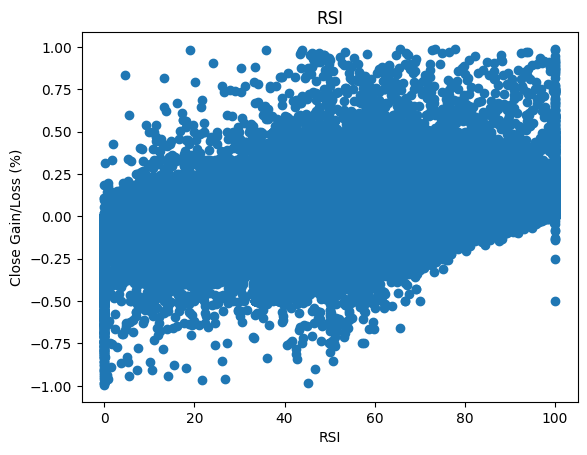

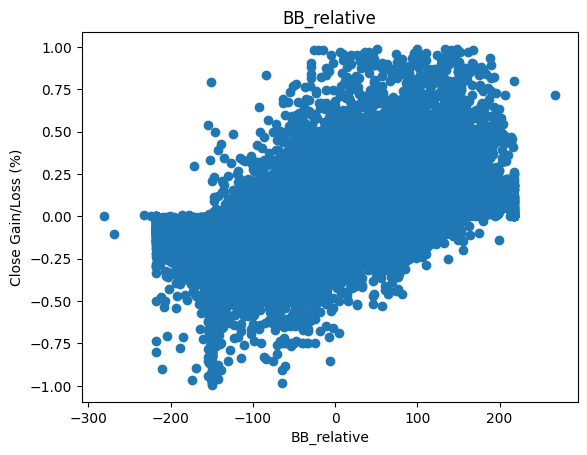

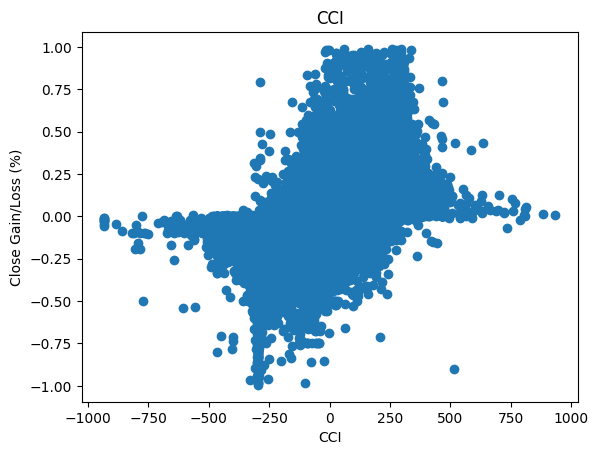

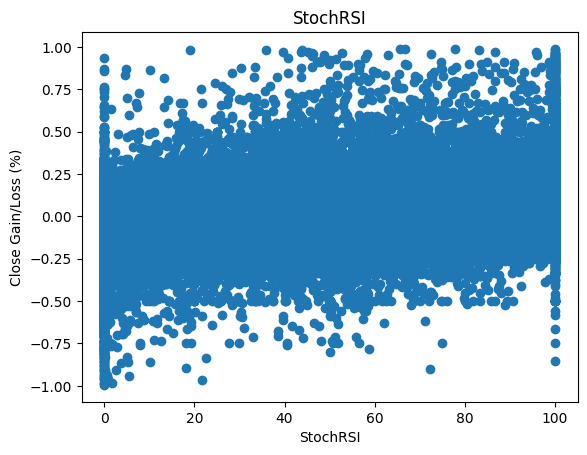

In [7]:
for label in features_X :
    plt.scatter(df[label], df["Close_gp"])
    plt.title(label)
    plt.ylabel("Close Gain/Loss (%)")
    plt.xlabel(label)
    plt.show()

In [8]:
df_no_tsla = df[df["ticker"] != "TSLA"]
df_tsla = df[df["ticker"] == "TSLA"]
train, valid, test = np.split(df_no_tsla.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df)) ])

/opt/miniconda3/envs/env313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
#function to scale the data properly
def scale_dataset(dataframe, features_X, features_y, oversample=False,) :
    X = dataframe[features_X].values
    y = dataframe[features_y].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample :
        ros = RandomOverSampler()
        X,y = ros.fit_resample(X,y)

    # data = np.hstack((X, np.reshape(y, (-1,1))))
    return X, y

In [10]:
X_train, y_train = scale_dataset(train, features_X, features_y, oversample=False)
X_valid, y_valid = scale_dataset(valid, features_X, features_y, oversample=False) #don't over sample for valid and test
X_test, y_test = scale_dataset(test, features_X, features_y, oversample=False)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)


In [ ]:
plt.scatter(y_test, y_pred)
plt.title("y")
plt.ylabel("y_pred")
plt.xlabel("y_test")
plt.show()

In [ ]:
# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [ ]:
df_tsla.iloc[-1].values